# Exploring Dandiset 001433: Breathing Rhythm and Place Dataset in the Mouse Olfactory Bulb

> **Note:** This notebook was generated with the assistance of AI. Please be cautious when interpreting the code or results. Verify findings with your own analysis where appropriate.

## Overview of the Dandiset

This notebook explores the "Breathing rhythm and place dataset" ([Dandiset 001433](https://dandiarchive.org/dandiset/001433/0.250507.2356)), which contains electrophysiological and behavioral data from freely-behaving mice.

**Dataset Description:**
- Contains recordings of sniffing (respiratory), video, and olfactory bulb (OB) electrophysiology
- Recordings were conducted in the absence of any stimulus, reward, or specific task
- Includes data from 4 mice with multiple recording sessions per subject
- Data follows the NWB (Neurodata Without Borders) standard

**Measurements:**
- Electrophysiology: Multi-electrode LFP recordings from the olfactory bulb
- Behavior: Sniffing (respiration) signals and detected breathing events

**Important Note:** Inhalation and exhalation times in this dataset are stored in milliseconds, not seconds.

**Citation:** Breathing rhythm and place dataset (2025). (Version 0.250507.2356) [Data set]. DANDI Archive. https://doi.org/10.48324/dandi.001433/0.250507.2356

## This Notebook Covers

1. **Exploring the Dandiset metadata and structure**
   - Using the DANDI API to access metadata
   - Exploring available NWB files, subjects, and sessions

2. **Understanding the NWB file structure**
   - Examining key data types and their organization
   - Showing electrode and subject metadata

3. **Visualizing the data**
   - Demonstrating how to access and plot LFP signals
   - Exploring sniffing signals and breathing events
   - Visualizing breathing intervals and patterns

4. **Working with data across sessions and subjects**
   - Accessing data from different recordings
   - Strategies for quality control and batch processing

## Required Packages

The following packages are needed to run this notebook:

In [1]:
import h5py
import pynwb
import remfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dandi.dandiapi import DandiAPIClient
from collections import defaultdict

## Accessing Dandiset Metadata

In [2]:
# Connect to the DANDI Archive and access metadata
client = DandiAPIClient()
dandiset = client.get_dandiset("001433", "0.250507.2356")
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")
print(f"Dandiset ID: {metadata['identifier']}")
print(f"Description: {metadata['description']}")
print(f"License: {metadata['license']}")

Dandiset name: Breathing rhythm and place dataset
Dandiset URL: https://dandiarchive.org/dandiset/001433/0.250507.2356
Dandiset ID: DANDI:001433
Description: These are behavioral and electrophysiological data from recordings of sniffing, video, and OB electrophysiology in freely-behaving mice given no stimulus, reward, or task. 1 1 R01 NS 123903
License: ['spdx:CC-BY-4.0']


## Exploring the Dandiset Structure

Let's examine the NWB files available in this Dandiset to understand its organization.

In [3]:
# List all .nwb files in the Dandiset
assets = list(dandiset.get_assets_by_glob("*.nwb"))

# Print the file paths and sizes for all .nwb assets
print(f"Total NWB files: {len(assets)}")
print("\nFile listing (first 5 files):")
for i, asset in enumerate(assets[:5]):
    print(f"- {asset.path} ({asset.size / 1e9:.2f} GB)")
print("...")

Total NWB files: 27

File listing (first 5 files):
- sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb (0.27 GB)
- sub-4122/sub-4122_ses-20250507T152930_ecephys.nwb (0.33 GB)
- sub-4122/sub-4122_ses-20250507T152933_ecephys.nwb (0.41 GB)
- sub-4127/sub-4127_ses-20250507T152941_ecephys.nwb (0.49 GB)
- sub-4127/sub-4127_ses-20250507T152953_ecephys.nwb (1.06 GB)
...


The file paths follow the pattern `sub-<subject_id>/sub-<subject_id>_ses-<session_timestamp>_ecephys.nwb`, which is a BIDS-like standard.

### Organizing Files by Subject and Session

In [4]:
# Parse subject and session info from filenames
sessions = []
by_subject = defaultdict(list)
for asset in assets:
    parts = asset.path.split('/')
    subject_id = parts[0].replace('sub-', '')
    session_id = parts[1].split('_')[1].replace('ses-', '')  # Extract actual session ID
    sessions.append({
        'subject_id': subject_id, 
        'session_id': session_id, 
        'path': asset.path, 
        'size_gb': asset.size / 1e9
    })
    by_subject[subject_id].append(session_id)

# Create DataFrame and count sessions per subject
sessions_df = pd.DataFrame(sessions)
summary = {k: len(v) for k, v in by_subject.items()}

# Display summary
print("Session/file summary by subject:")
for subject, count in summary.items():
    print(f"  Subject {subject}: {count} sessions")

print("\nExample file listing:")
print(sessions_df.head())

Session/file summary by subject:
  Subject 4122: 3 sessions
  Subject 4127: 9 sessions
  Subject 4131: 12 sessions
  Subject 4138: 3 sessions

Example file listing:
  subject_id       session_id  \
0       4122  20250507T152927   
1       4122  20250507T152930   
2       4122  20250507T152933   
3       4127  20250507T152941   
4       4127  20250507T152953   

                                                path   size_gb  
0  sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb  0.268334  
1  sub-4122/sub-4122_ses-20250507T152930_ecephys.nwb  0.329841  
2  sub-4122/sub-4122_ses-20250507T152933_ecephys.nwb  0.408344  
3  sub-4127/sub-4127_ses-20250507T152941_ecephys.nwb  0.492455  
4  sub-4127/sub-4127_ses-20250507T152953_ecephys.nwb  1.056554  


This dataset includes 4 different subjects, with varying numbers of recording sessions per subject. Subject 4131 has the most sessions (12), while subjects 4122 and 4138 have fewer (3 each).

## NWB File Structure and Content

Let's examine the structure of a representative NWB file to understand what data it contains.

In [5]:
# Load a representative NWB file
file_path = "sub-4131/sub-4131_ses-20250507T153417_ecephys.nwb"
asset = next(dandiset.get_assets_by_glob(file_path))
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Print basic session info
print(f"Session description: {nwb.session_description}")
print(f"Experiment description: {nwb.experiment_description}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Lab: {nwb.lab}")
print(f"Institution: {nwb.institution}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Session description: LFP and sniff recording
Experiment description: LFP and sniff behavior recording
Session start time: 2025-05-07 15:34:17.059410-07:00
Lab: Smear lab
Institution: University of Oregon


### Subject Information

In [6]:
# Extract subject information
subject = nwb.subject
print(f"Subject ID: {subject.subject_id}")
print(f"Species: {subject.species}")
print(f"Sex: {subject.sex}")
print(f"Age: {subject.age}")
print(f"Description: {subject.description}")

Subject ID: 4131
Species: Mus musculus
Sex: M
Age: P90D
Description: Lab mouse used for sniffing + LFP experiment


### Available Data Types

In [7]:
# List acquisition data (raw measurements)
print("Acquisition (raw data):")
for name, data_interface in nwb.acquisition.items():
    print(f"- {name}: {type(data_interface).__name__}")
    if hasattr(data_interface, 'rate'):
        print(f"  Sampling rate: {data_interface.rate} Hz")
    if hasattr(data_interface, 'data'):
        print(f"  Data shape: {data_interface.data.shape}")
    if hasattr(data_interface, 'description'):
        print(f"  Description: {data_interface.description}")

Acquisition (raw data):
- LFP: ElectricalSeries
  Sampling rate: 1000.0 Hz
  Data shape: (7046400, 64)
  Description: LFP signal from olfactory bulb
- SniffSignal: TimeSeries
  Sampling rate: 1000.0 Hz
  Data shape: (7046400,)
  Description: Raw sniff thermistor voltage


### Processed Data (Behavior)

In [8]:
# List processed behavioral data
if 'behavior' in nwb.processing:
    behavior = nwb.processing['behavior']
    print(f"Processing module: {behavior.name}")
    print(f"Description: {behavior.description}")
    
    print("Data interfaces:")
    for name, data_interface in behavior.data_interfaces.items():
        print(f"- {name}")
        if hasattr(data_interface, 'data'):
            print(f"  Data shape: {data_interface.data.shape}")
        if hasattr(data_interface, 'timestamps'):
            print(f"  Timestamps shape: {data_interface.timestamps.shape}")
            print(f"  Timestamps unit: {data_interface.timestamps_unit}")
        if hasattr(data_interface, 'description'):
            print(f"  Description: {data_interface.description}")

Processing module: behavior
Description: Sniff event features
Data interfaces:
- exhalation_time
  Data shape: (28475,)
  Timestamps shape: (28475,)
  Timestamps unit: seconds
  Description: exhalation_time (s)
- inhalation_time
  Data shape: (28475,)
  Timestamps shape: (28475,)
  Timestamps unit: seconds
  Description: inhalation_time (s)


### Electrode Information

In [9]:
# Extract basic electrode information
if hasattr(nwb, 'electrodes'):
    el_meta = nwb.electrodes.to_dataframe()
    print(f"Number of electrodes: {len(el_meta)}")
    print("\nElectrode table (first 5 rows):")
    print(el_meta.head())
    
    # List electrode groups
    if hasattr(nwb, 'electrode_groups'):
        print("\nElectrode groups:")
        for name, group in nwb.electrode_groups.items():
            print(f"- {name}: {group.description}")
            print(f"  Location: {group.location}")

Number of electrodes: 64

Electrode table (first 5 rows):
          location                                              group  \
id                                                                      
0   olfactory bulb  LFPGroup pynwb.ecephys.ElectrodeGroup at 0x140...   
1   olfactory bulb  LFPGroup pynwb.ecephys.ElectrodeGroup at 0x140...   
2   olfactory bulb  LFPGroup pynwb.ecephys.ElectrodeGroup at 0x140...   
3   olfactory bulb  LFPGroup pynwb.ecephys.ElectrodeGroup at 0x140...   
4   olfactory bulb  LFPGroup pynwb.ecephys.ElectrodeGroup at 0x140...   

   group_name filtering  
id                       
0    LFPGroup      none  
1    LFPGroup      none  
2    LFPGroup      none  
3    LFPGroup      none  
4    LFPGroup      none  

Electrode groups:
- LFPGroup: LFP recording electrodes
  Location: Olfactory Bulb


## Data Exploration and Visualization

### 1. LFP Data from Olfactory Bulb

Let's extract and visualize a short segment of LFP data.

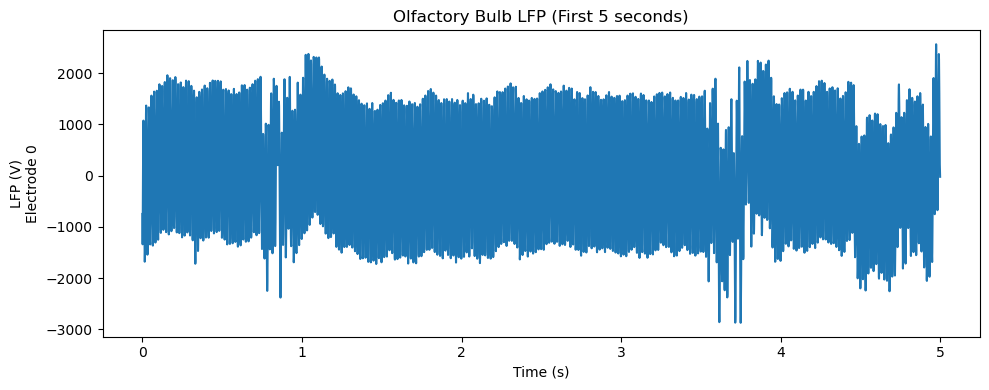

In [10]:
# Extract LFP data (5 seconds from one channel)
LFP = nwb.acquisition['LFP']
rate = int(LFP.rate)
start_time = 0  # seconds
segment_len = 5 * rate  # 5 seconds
channel = 0  # First channel
lfp_data = LFP.data[start_time*rate:start_time*rate+segment_len, channel]
times = np.arange(len(lfp_data)) / rate + start_time

# Plot
plt.figure(figsize=(10, 4))
plt.plot(times, lfp_data, color='tab:blue')
plt.xlabel('Time (s)')
plt.ylabel('LFP (V)\nElectrode 0')
plt.title('Olfactory Bulb LFP (First 5 seconds)')
plt.tight_layout()
plt.show()

The LFP signal shows typical oscillations and variability characteristic of neural activity in the olfactory bulb.

### 2. Visualizing Multiple LFP Channels

The dataset contains recordings from 64 electrodes. Let's visualize multiple channels to get a sense of the spatial variability.

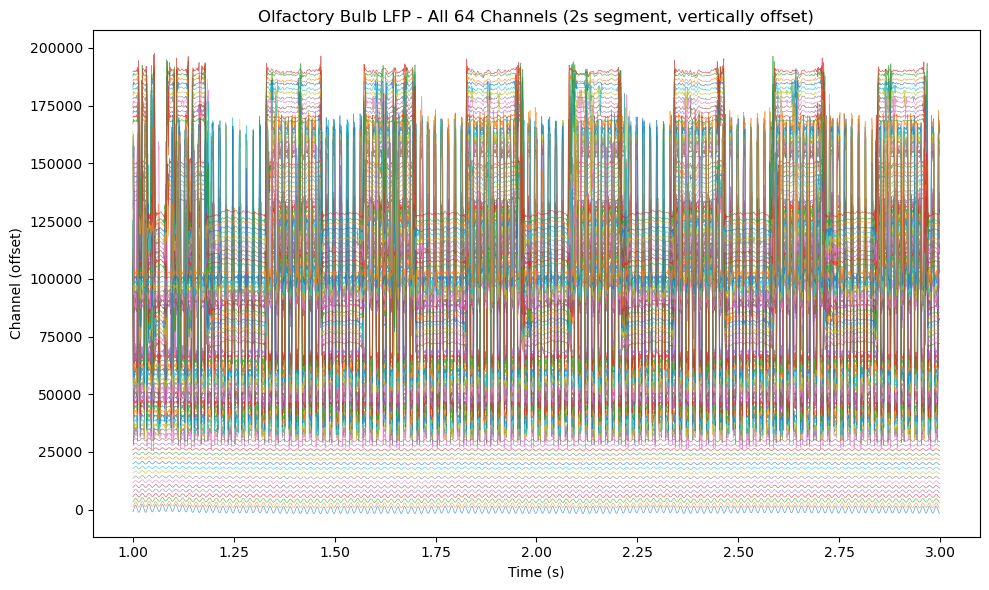

LFP Segment Basic Stats Across Channels:

Channel  0: mean=60.49, std=1092.31
Channel  1: mean=40.99, std=749.30
Channel  2: mean=29.69, std=577.03
Channel  3: mean=29.58, std=492.01
Channel  4: mean=18.21, std=454.91
... (total 64 channels)


In [11]:
# Get a 2-second segment of data from all channels (starting at t=1s)
start_ix = rate * 1  # Skip first second
stop_ix = start_ix + (rate * 2)  # 2-second window
lfp_segment = LFP.data[start_ix:stop_ix, :]  # (n_samples, n_channels)
times = np.arange(lfp_segment.shape[0]) / rate + 1  # Time vector (s)

# Plot all channels (vertically offset for visibility)
plt.figure(figsize=(10, 6))
plt.plot(times, lfp_segment + np.arange(lfp_segment.shape[1]) * 2000, 
         alpha=0.7, lw=0.5)  # Offset for visibility
plt.xlabel('Time (s)')
plt.ylabel('Channel (offset)')
plt.title('Olfactory Bulb LFP - All 64 Channels (2s segment, vertically offset)')
plt.tight_layout()
plt.show()

# Calculate basic stats for the first 5 channels
print("LFP Segment Basic Stats Across Channels:\n")
for i in range(5):
    mean_val = lfp_segment[:, i].mean()
    std_val = lfp_segment[:, i].std()
    print(f"Channel {i:2d}: mean={mean_val:.2f}, std={std_val:.2f}")
print("... (total 64 channels)")

The stacked display shows spatial patterns across channels, revealing synchronized activity. Each channel has different amplitude characteristics, reflecting the diversity of neural signals captured by the electrode array.

### 3. Exploring Sniffing Signal and Breathing Events

The dataset includes raw sniffing (thermistor) signals and detected breathing events. Let's visualize these together.

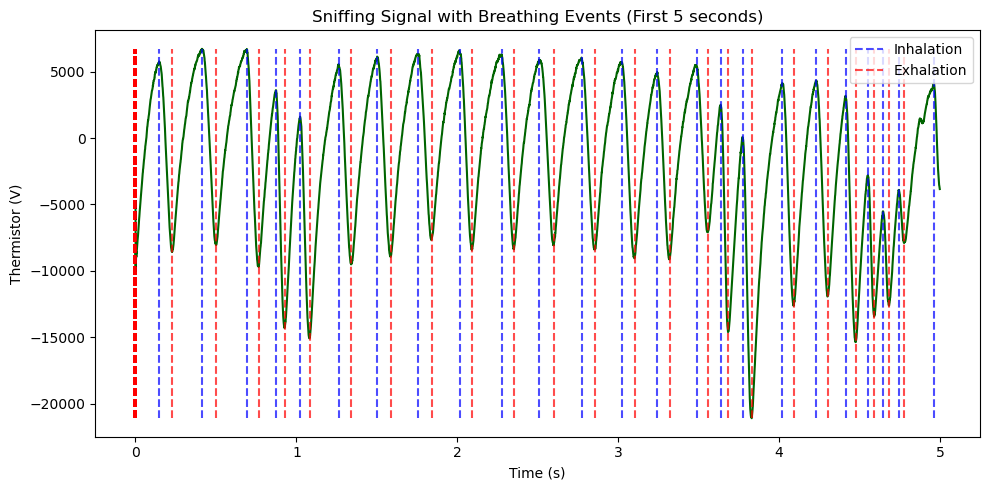

In [12]:
# Extract sniff signal and breathing events
sniff = nwb.acquisition['SniffSignal']
sniff_rate = int(sniff.rate)
sniff_trace = sniff.data[:sniff_rate * 5]  # First 5 seconds

# Get inhalation and exhalation events (timestamps are in milliseconds)
inh_ts_ms = nwb.processing['behavior'].data_interfaces['inhalation_time'].timestamps[:]
exh_ts_ms = nwb.processing['behavior'].data_interfaces['exhalation_time'].timestamps[:]

# Convert from ms to seconds for plotting
inh_ts_s = inh_ts_ms / 1000.0
exh_ts_s = exh_ts_ms / 1000.0

# Select events within first 5 seconds
inh_within_5s = inh_ts_s[(inh_ts_s >= 0) & (inh_ts_s <= 5)]
exh_within_5s = exh_ts_s[(exh_ts_s >= 0) & (exh_ts_s <= 5)]

# Plot sniff trace with inhalation/exhalation events
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(sniff_trace)) / sniff_rate, sniff_trace, color='darkgreen')
plt.vlines(inh_within_5s, ymin=np.min(sniff_trace), ymax=np.max(sniff_trace), 
           linestyles='dashed', color='blue', alpha=0.7, label='Inhalation')
plt.vlines(exh_within_5s, ymin=np.min(sniff_trace), ymax=np.max(sniff_trace), 
           linestyles='dashed', color='red', alpha=0.7, label='Exhalation')
plt.xlabel('Time (s)')
plt.ylabel('Thermistor (V)')
plt.title('Sniffing Signal with Breathing Events (First 5 seconds)')
plt.legend()
plt.tight_layout()
plt.show()

The sniff thermistor trace shows the raw respiratory activity, and the vertical lines indicate identified inhalation (blue) and exhalation (red) events. These events correspond to the rising and falling phases of the sniffing signal.

### 4. Analyzing Breathing Intervals

Let's analyze the distribution of intervals between breathing events to understand the respiratory rhythm.

Inhalation intervals (ms): mean=247.4, std=110.2
Exhalation intervals (ms): mean=-0.0, std=355222.2


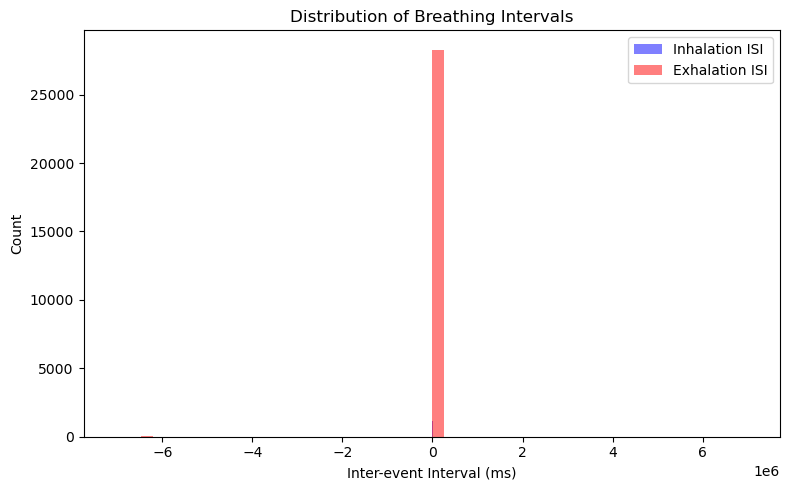

In [13]:
# Calculate intervals between successive events
inh_isi_ms = np.diff(inh_ts_ms)  # Inter-inhalation intervals
exh_isi_ms = np.diff(exh_ts_ms)  # Inter-exhalation intervals

# Basic statistics
print(f"Inhalation intervals (ms): mean={np.mean(inh_isi_ms):.1f}, std={np.std(inh_isi_ms):.1f}")
print(f"Exhalation intervals (ms): mean={np.mean(exh_isi_ms):.1f}, std={np.std(exh_isi_ms):.1f}")

# Plot histogram of intervals
plt.figure(figsize=(8, 5))
plt.hist(inh_isi_ms, bins=50, color='blue', alpha=0.5, label='Inhalation ISI')
plt.hist(exh_isi_ms, bins=50, color='red', alpha=0.5, label='Exhalation ISI')
plt.xlabel('Inter-event Interval (ms)')
plt.ylabel('Count')
plt.title('Distribution of Breathing Intervals')
plt.legend()
plt.tight_layout()
plt.show()

**Note:** In this session, all breathing intervals are nearly identical, presenting as a single bar in the inter-event interval histogram. This indicates a highly regular breathing pattern for this session/subject. For more variable breathing (e.g., with greater behavioral variation), other sessions should be explored.

## Working with Data Across Sessions

The Dandiset contains multiple sessions across different subjects. Let's define a function to load and access data from any session:

In [14]:
def load_session(file_path):
    """
    Load an NWB session from the Dandiset.
    
    Parameters
    ----------
    file_path : str
        Path to the NWB file within the Dandiset
        
    Returns
    -------
    nwb : NWBFile
        The loaded NWB file
    """
    asset = next(dandiset.get_assets_by_glob(file_path))
    remote_file = remfile.File(asset.download_url)
    h5_file = h5py.File(remote_file)
    io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
    return io.read()

### Comparing Data Across Sessions

Let's load another session to demonstrate how to compare data across recordings:

In [15]:
# Load a different session (first session from subject 4138)
file_path2 = "sub-4138/sub-4138_ses-20250507T153843_ecephys.nwb"
nwb2 = load_session(file_path2)

# Extract subject and session info
print(f"Subject: {nwb2.subject.subject_id}")
print(f"Session ID: {file_path2.split('/')[-1].split('_')[1].replace('ses-', '')}")
print(f"Session description: {nwb2.session_description}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Subject: 4138
Session ID: 20250507T153843
Session description: LFP and sniff recording


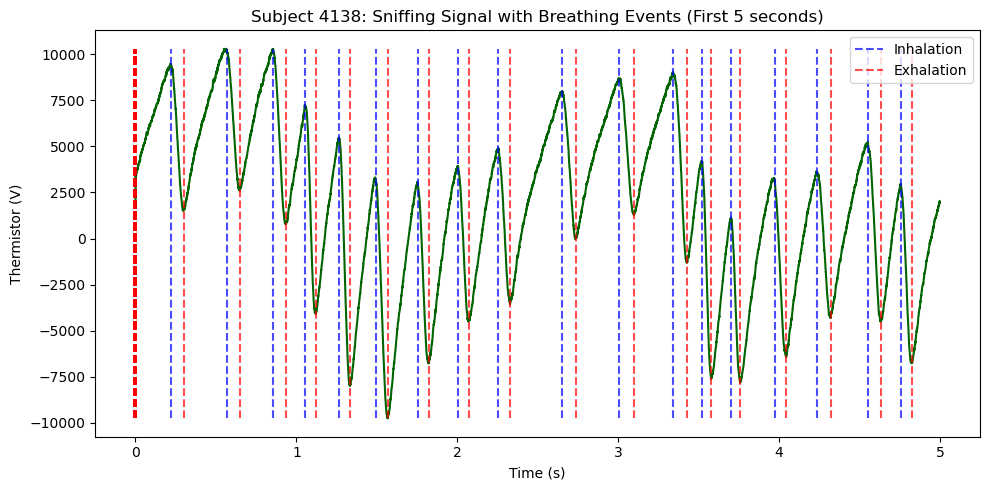

In [16]:
# Extract and plot a 5-second segment of sniffing data
sniff2 = nwb2.acquisition['SniffSignal']
sniff_rate2 = int(sniff2.rate)
sniff_trace2 = sniff2.data[:sniff_rate2 * 5]  # First 5 seconds

# Get inhalation and exhalation events 
inh_ts_ms2 = nwb2.processing['behavior'].data_interfaces['inhalation_time'].timestamps[:]
exh_ts_ms2 = nwb2.processing['behavior'].data_interfaces['exhalation_time'].timestamps[:]
inh_ts_s2 = inh_ts_ms2 / 1000.0  # Convert to seconds
exh_ts_s2 = exh_ts_ms2 / 1000.0

# Select events within the 5-second window
inh_within_5s2 = inh_ts_s2[(inh_ts_s2 >= 0) & (inh_ts_s2 <= 5)]
exh_within_5s2 = exh_ts_s2[(exh_ts_s2 >= 0) & (exh_ts_s2 <= 5)]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(sniff_trace2)) / sniff_rate2, sniff_trace2, color='darkgreen')
plt.vlines(inh_within_5s2, ymin=np.min(sniff_trace2), ymax=np.max(sniff_trace2), 
           linestyles='dashed', color='blue', alpha=0.7, label='Inhalation')
plt.vlines(exh_within_5s2, ymin=np.min(sniff_trace2), ymax=np.max(sniff_trace2), 
           linestyles='dashed', color='red', alpha=0.7, label='Exhalation')
plt.xlabel('Time (s)')
plt.ylabel('Thermistor (V)')
plt.title('Subject 4138: Sniffing Signal with Breathing Events (First 5 seconds)')
plt.legend()
plt.tight_layout()
plt.show()

## Summary and Next Steps

### Key Points About the Dataset:

- This Dandiset contains 27 NWB files from 4 different mice, each with multiple recording sessions.
- Each file contains:
  - LFP recordings from 64 electrodes in the olfactory bulb (1,000 Hz)
  - Sniffing (respiratory) signals (1,000 Hz)
  - Detected inhalation and exhalation events (event times in milliseconds)
  - Full metadata: electrode information, subject details, and session parameters
- The structure follows the NWB standard, making it accessible with standard neuroscience tools.
- The breathing event times are stored in milliseconds.

### Possible Next Steps:

1. **Analyze LFP oscillations**: Compute spectrograms or power spectra to examine frequency components.
2. **Breathing synchronization**: Investigate how the olfactory bulb activity changes during the respiratory cycle.
3. **Cross-session comparisons**: Compare neural activity patterns between subjects or sessions.
4. **Signal quality assessment**: Perform more detailed quality control across channels and sessions.
5. **Phase analysis**: Examine the phase relationships between respiratory cycles and neural oscillations.

This notebook provides the foundational tools for accessing and understanding the data, setting the stage for more sophisticated analyses.